In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def draw_bbox(image,points):
  # function to draw a bounding box on the image to verify correctness of selected points
  copy_image=image.copy()
  points_reshape = points.reshape((-1, 1, 2))   # reshape the points according to the requirements of cv2
  color = (255, 0, 0)   
  im1_bbox = cv2.polylines(copy_image, [points_reshape], isClosed=True,color=color,thickness = 10)
  plt.figure()
  plt.axis('off')  
  plt.imshow(im1_bbox) 
  plt.title("Bounding Box")
  #plt.imsave("bounding box1.jpeg",im1_bbox)

def Homography_matrix(X,X_prime):
  '''
  This function takes input X and X_prime and computes the homography between them. Returns a 3x3 non-singular matrix
  H. 
  '''
  H = np.ones((3,3))  #Initialise the Homography matrix
  A = np.zeros((8,8)) #initialise a matrix
   

  C=X_prime   

  #build the A matrix column by column
  for i in range(0,4):
    A[2*i,0]=X[2*i]
    A[2*i,1]=X[2*i+1]
    A[2*i,2]=1
    A[2*i+1,3]=X[2*i]
    A[2*i+1,4]=X[2*i+1]
    A[2*i+1,5]=1
    A[2*i,6]=X[2*i]*X_prime[2*i]
    A[2*i+1,6]=X[2*i]*X_prime[2*i+1]
    A[2*i,7]=(X[2*i+1]*X_prime[2*i])
    A[2*i+1,7]=(X[2*i+1]*X_prime[2*i+1])
  A[:,6:]=-A[:,6:]
  
  #B=(A^-1)C
  B=np.dot(np.linalg.inv(A),C)

  #reshape the B vector to get the homography matrix
  H[0,0]=B[0]
  H[0,1]=B[1]
  H[0,2]=B[2]
  H[1,0]=B[3]
  H[1,1]=B[4]
  H[1,2]=B[5]
  H[2,0]=B[6]
  H[2,1]=B[7]
  H[2,2]=1
  return H



def get_4_points(n):
  if n==1:  #image 1a
    #in order to get a better image made use of multiple windows and assumed the image coordinates in world plane accordingly.
    P=[117,586]   #x1,y1
    Q=[876,680]  #x2,y2
    R=[865,297] #x3,y3
    S=[175,76]  #x4,y4
  elif n==2:
    P=[379,838]   #x1,y1
    Q=[606,924]  #x2,y2
    R=[598,545] #x3,y3
    S=[378,570]  #x4,y4
  elif n ==3:
    P=[2092,1481]   #x1,y1
    Q=[2693,1322] #x2,y2
    R=[2667,717] #x3,y3
    S=[2057,700]  #x4,y4
  
  X_prime=P+Q+R+S
  return np.array([P,Q,R,S]),X_prime

#assume distance between the edges of two windows to be equal to the window size
def get_world_points(n):
  #world points scaled accordingly to the points selected in the image
  if n == 1:
    P_dash=[0,85*15]
    Q_dash=[75*23,85*15]
    R_dash=[75*23,0]
    S_dash=[0,0]
  elif n == 2:
    P_dash=[0,148]
    Q_dash=[168,148]
    R_dash=[168,0]
    S_dash=[0,0]
  elif n == 3:
    P_dash=[0,36]
    Q_dash=[55,36]
    R_dash=[55,0]
    S_dash=[0,0]
  X=P_dash+Q_dash+R_dash+S_dash
  return np.array([P_dash,Q_dash,R_dash,S_dash]),X

In [3]:
def get_new_coords(img,H):
  # this function returns the size of the image in the world coordinates after transformation

  width=img.shape[1]
  height=img.shape[0]
  print("width(x)=",width)
  print("height(y)=",height)

  img_coords=np.array([[0,0,1],[0,height,1],[width,0,1],[width,height,1]])  # 4 corners of the image in homogenous coordinates
  print("image coordinates: ",img_coords.T)

  new_coords=np.matmul(H,img_coords.T)  
  new_coords=new_coords/new_coords[2]
  new_coords=np.rint(new_coords).astype(int)
  new_img_coords=new_coords.T[:,:2]
  print("new image coordinates: ",new_img_coords)
  return new_img_coords

In [7]:
def get_mapped_image(im1, new_img_coords,H_inv):
  '''
  We can see from the projected corner points that the origin in this new coordinate is not at (0,0). Hence we need 
  to find the appropriate translation to bring the coordinates along origin.  
  
  Also we need to scale the image so that the final image size is not very large.
  '''
  height,width,_ = im1.shape
  scale1=width/(max(new_img_coords[:,0])-min(new_img_coords[:,0]))  # get a sale along the width (actual width/project_width)
  scale2=height/(max(new_img_coords[:,1])-min(new_img_coords[:,1])) # get a sale along the height (actual height/project_height)
  scale=max(scale1, scale2)   # select the max value as the scale for both width and height (or can use different scales)
  print("scale: ",scale)

  #find the translation to bring the coordinates to positive values
  tx=np.round(np.min(new_img_coords[:,0]))
  ty=np.round(np.min(new_img_coords[:,1]))
  print("tx,ty",tx,ty)

  '''
  Find out the shape of the new image in world coordinates.
  '''

  new_height=np.round((max(new_img_coords[:,1])-min(new_img_coords[:,1]))*scale2).astype(int)
  new_width=np.round((max(new_img_coords[:,0])-min(new_img_coords[:,0]))*scale1).astype(int)
  
  new_image=np.zeros((new_height,new_width,3))

  max_X=im1.shape[1]    # this value will be used to check if the mapped pixels are within the range of the original image so that pixel values are present for them 
  max_Y=im1.shape[0]

  '''
  To find the mapping of every point in the new image to the distorted image, we multiply every point with the inverse
  of the Homography - i.e. map every point in real world coordinates to the image plane and find the correspondence.
  '''
  
  for i in range(0,new_width):  #x
    for j in range(0,new_height): #y

      k1=i/scale1+tx
      k2=j/scale2+ty
      init=np.array((k1,k2,1))
      mapped=np.matmul(H_inv,init)
      mapped=np.rint(mapped/mapped[2])
      mapped=mapped.astype(int)
      if mapped[0]>=0 and mapped[0]<max_X and mapped[1]>=0 and mapped[1]<max_Y:
        new_image[j,i]=im1[mapped[1],mapped[0]]
  
  return new_image.astype(int)

In [8]:
def Rectification(image_num):
  # wrapper function to carry out all functions and return rectified image..
  print("Current Image:",image_num)  
  if image_num == 1:
    image = cv2.imread("/content/drive/My Drive/hw3_Task1_Images/Images/Img1.JPG")
  elif image_num == 2:
    image = cv2.imread("/content/drive/My Drive/hw3_Task1_Images/Images/Img2.jpeg")
  elif image_num == 3:
    image = cv2.imread("/content/drive/My Drive/hw3_Task1_Images/Images/Img3.JPG")
  else:
    print("Image does not exist.. Choose between 1-3")
  image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  im1 = np.copy(image_orig)
  plt.figure()
  plt.imshow(im1)
  plt.title("Original Image")

  #get the points in the image and world frames
  P1,X=get_4_points(image_num)
  P2,X_prime=get_world_points(image_num)

  draw_bbox(im1,P1)   # draw the bounding box to check for correctness of the points

  #compute the Homography between the points
  H=Homography_matrix(X,X_prime)
  print("H=",H)
  H_inv=np.linalg.inv(H)

  new_img_coords = get_new_coords(im1,H)
  mapped_img = get_mapped_image(im1,new_img_coords,H_inv)
  plt.figure()
  plt.imshow(mapped_img)
  plt.title("Mapped image")

Current Image: 1
H= [[ 1.67400454e+00  1.90376987e-01 -3.07419445e+02]
 [-8.03806680e-01  2.50962267e+00 -5.00651536e+01]
 [-4.05225724e-04  1.49873378e-04  1.00000000e+00]]
width(x)= 1600
height(y)= 1200
image coordinates:  [[   0    0 1600 1600]
 [   0 1200    0 1200]
 [   1    1    1    1]]
new image coordinates:  [[ -307   -50]
 [  -67  2510]
 [ 6743 -3800]
 [ 4891  3152]]
scale:  0.22695035460992907
tx,ty -307 -3800
Current Image: 2
H= [[ 4.11944700e+00 -1.53710709e-02 -1.54838945e+03]
 [ 2.46059696e-01  2.16532533e+00 -1.32724600e+03]
 [ 7.10078580e-03  2.76204360e-04  1.00000000e+00]]
width(x)= 768
height(y)= 1024
image coordinates:  [[   0    0  768  768]
 [   0 1024    0 1024]
 [   1    1    1    1]]
new image coordinates:  [[-1548 -1327]
 [-1219   694]
 [  250  -176]
 [  237   160]]
scale:  0.5066798614547254
tx,ty -1548 -1327
Current Image: 3
H= [[ 3.98865776e-02 -1.78749067e-03 -8.07954466e+01]
 [-7.32223984e-04  2.62739194e-02 -1.68855589e+01]
 [-2.11372650e-04  7.75002405

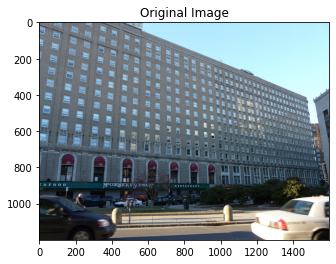

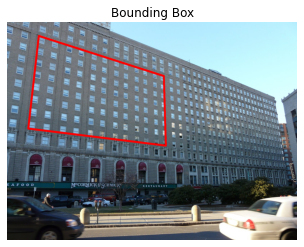

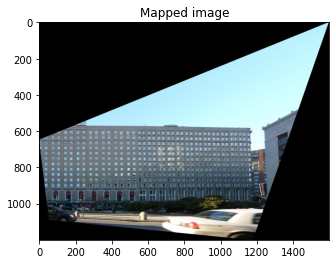

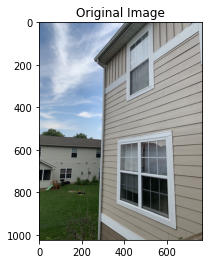

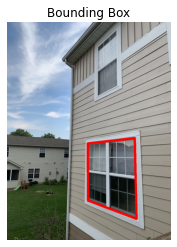

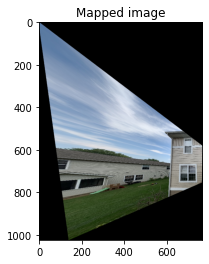

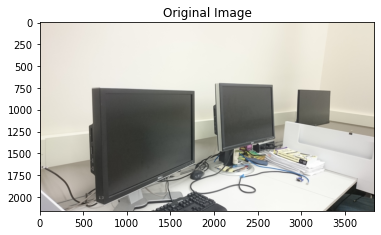

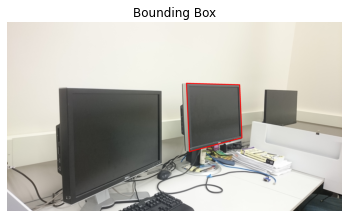

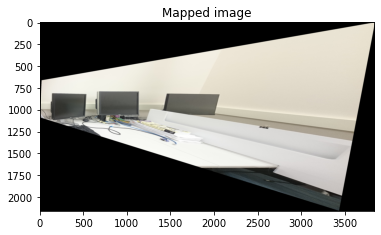

In [10]:
Rectification(1)
Rectification(2)
Rectification(3)